In [1]:
import pandas as pd

data = pd.read_csv('data_sample_three_years.csv')

data = data.iloc[:, [0,1,2,3,4]]
data.rename(columns={'date': 'open', 'low':'close', 'open':'high', 'high':'low'}, inplace=True)

data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.iloc[:, [0,5,1,2,3,4]]

data_backup = data.loc[ data.timestamp >= 1675814400 ]
data = data.loc[ data.timestamp < 1675814400 ]

In [2]:
data.shape

(16262, 6)

In [3]:
data.columns[5:]

Index(['close'], dtype='object')

In [4]:
seq_length = 10  # Number of time steps in each sequence
close_prices = data.close

In [5]:
close_prices.iloc[2]

1583.35

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Scaling the 'close' prices
scaler = MinMaxScaler()
data['close_scaled'] = scaler.fit_transform(data[['close']])

In [7]:
import numpy as np

# Create input sequences and targets
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length])  # Input sequence
        y.append(data.iloc[i+seq_length])    # Target value (next data point)
    return np.array(X), np.array(y)

In [8]:
X, y = create_sequences(data[['close_scaled']], seq_length)

In [9]:
X = X.reshape(X.shape[0], seq_length, 1)

In [10]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Build LSTM model
model = Sequential([
    LSTM(100, input_shape=(seq_length, 1)),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Adding early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model with early stopping
model.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

2024-03-28 05:03:45.607623: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-28 05:03:45.679304: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 05:03:45.679369: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 05:03:45.682524: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-28 05:03:45.695850: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-28 05:03:47.093849: W tensorflow/compiler/tf2tensorrt/utils/py_utils.

Epoch 1/100
407/407 [==============================] - 9s 14ms/step - loss: 0.0024 - val_loss: 3.3161e-05
Epoch 2/100
407/407 [==============================] - 6s 14ms/step - loss: 1.7417e-04 - val_loss: 3.0059e-05
Epoch 3/100
407/407 [==============================] - 6s 14ms/step - loss: 1.7009e-04 - val_loss: 2.3411e-05
Epoch 4/100
407/407 [==============================] - 6s 14ms/step - loss: 1.5881e-04 - val_loss: 1.9525e-05
Epoch 5/100
407/407 [==============================] - 6s 14ms/step - loss: 1.4930e-04 - val_loss: 1.9610e-05
Epoch 6/100
407/407 [==============================] - 6s 14ms/step - loss: 1.4871e-04 - val_loss: 1.6922e-05
Epoch 7/100
407/407 [==============================] - 5s 13ms/step - loss: 1.3247e-04 - val_loss: 1.6590e-05
Epoch 8/100
407/407 [==============================] - 5s 12ms/step - loss: 1.2297e-04 - val_loss: 1.5300e-05
Epoch 9/100
407/407 [==============================] - 5s 13ms/step - loss: 1.2570e-04 - val_loss: 1.6192e-05
Epoch 10/100
4

In [11]:
data_backup['close_scaled'] = scaler.transform(data_backup[['close']])
X_b, y_b = create_sequences(data_backup['close_scaled'], seq_length)
X_b = X_b.reshape(X_b.shape[0], seq_length, 1)

In [12]:
X_b

array([[[0.19852766],
        [0.19720068],
        [0.19569137],
        ...,
        [0.19604337],
        [0.19503295],
        [0.19501269]],

       [[0.19720068],
        [0.19569137],
        [0.19678537],
        ...,
        [0.19503295],
        [0.19501269],
        [0.19440744]],

       [[0.19569137],
        [0.19678537],
        [0.19637765],
        ...,
        [0.19501269],
        [0.19440744],
        [0.19521021]],

       ...,

       [[0.37193896],
        [0.37185032],
        [0.37013082],
        ...,
        [0.38376021],
        [0.38881995],
        [0.38655852]],

       [[0.37185032],
        [0.37013082],
        [0.3711058 ],
        ...,
        [0.38881995],
        [0.38655852],
        [0.38530244]],

       [[0.37013082],
        [0.3711058 ],
        [0.37828263],
        ...,
        [0.38655852],
        [0.38530244],
        [0.38516823]]])

In [13]:
y_pred = model.predict(X_b)

253/253 [==============================] - 2s 5ms/step


In [14]:
y_pred

array([[0.19515987],
       [0.19462547],
       [0.19523297],
       ...,
       [0.3870897 ],
       [0.38595554],
       [0.38587108]], dtype=float32)

In [15]:
y_pred = scaler.inverse_transform(y_pred)

In [16]:
y_pred

array([[1673.9111],
       [1671.801 ],
       [1674.1998],
       ...,
       [2431.8074],
       [2427.3289],
       [2426.9954]], dtype=float32)

In [17]:
data_backup[['close']]
data_backup.reset_index()

,index,timestamp,date,open,high,low,close,close_scaled
0,16262,1675814400,2023-02-08 00:00:00,1670.50,1691.52,1667.43,1687.21,0.198528
1,16263,1675818000,2023-02-08 01:00:00,1687.21,1699.00,1680.65,1681.97,0.197201
2,16264,1675821600,2023-02-08 02:00:00,1681.96,1684.03,1676.01,1676.01,0.195691
3,16265,1675825200,2023-02-08 03:00:00,1676.01,1683.17,1675.38,1680.33,0.196785
4,16266,1675828800,2023-02-08 04:00:00,1680.34,1682.60,1678.00,1678.72,0.196378
...,...,...,...,...,...,...,...,...
8092,24354,1707336000,2024-02-07 20:00:00,2418.66,2445.00,2418.66,2438.64,0.388820
8093,24355,1707339600,2024-02-07 21:00:00,2438.64,2439.27,2424.86,2429.71,0.386559
8094,24356,1707343200,2024-02-07 22:00:00,2429.71,2431.16,2421.03,2424.75,0.385302
8095,24357,1707346800,2024-02-07 23:00:00,2424.76,2429.61,2421.81,2424.22,0.385168


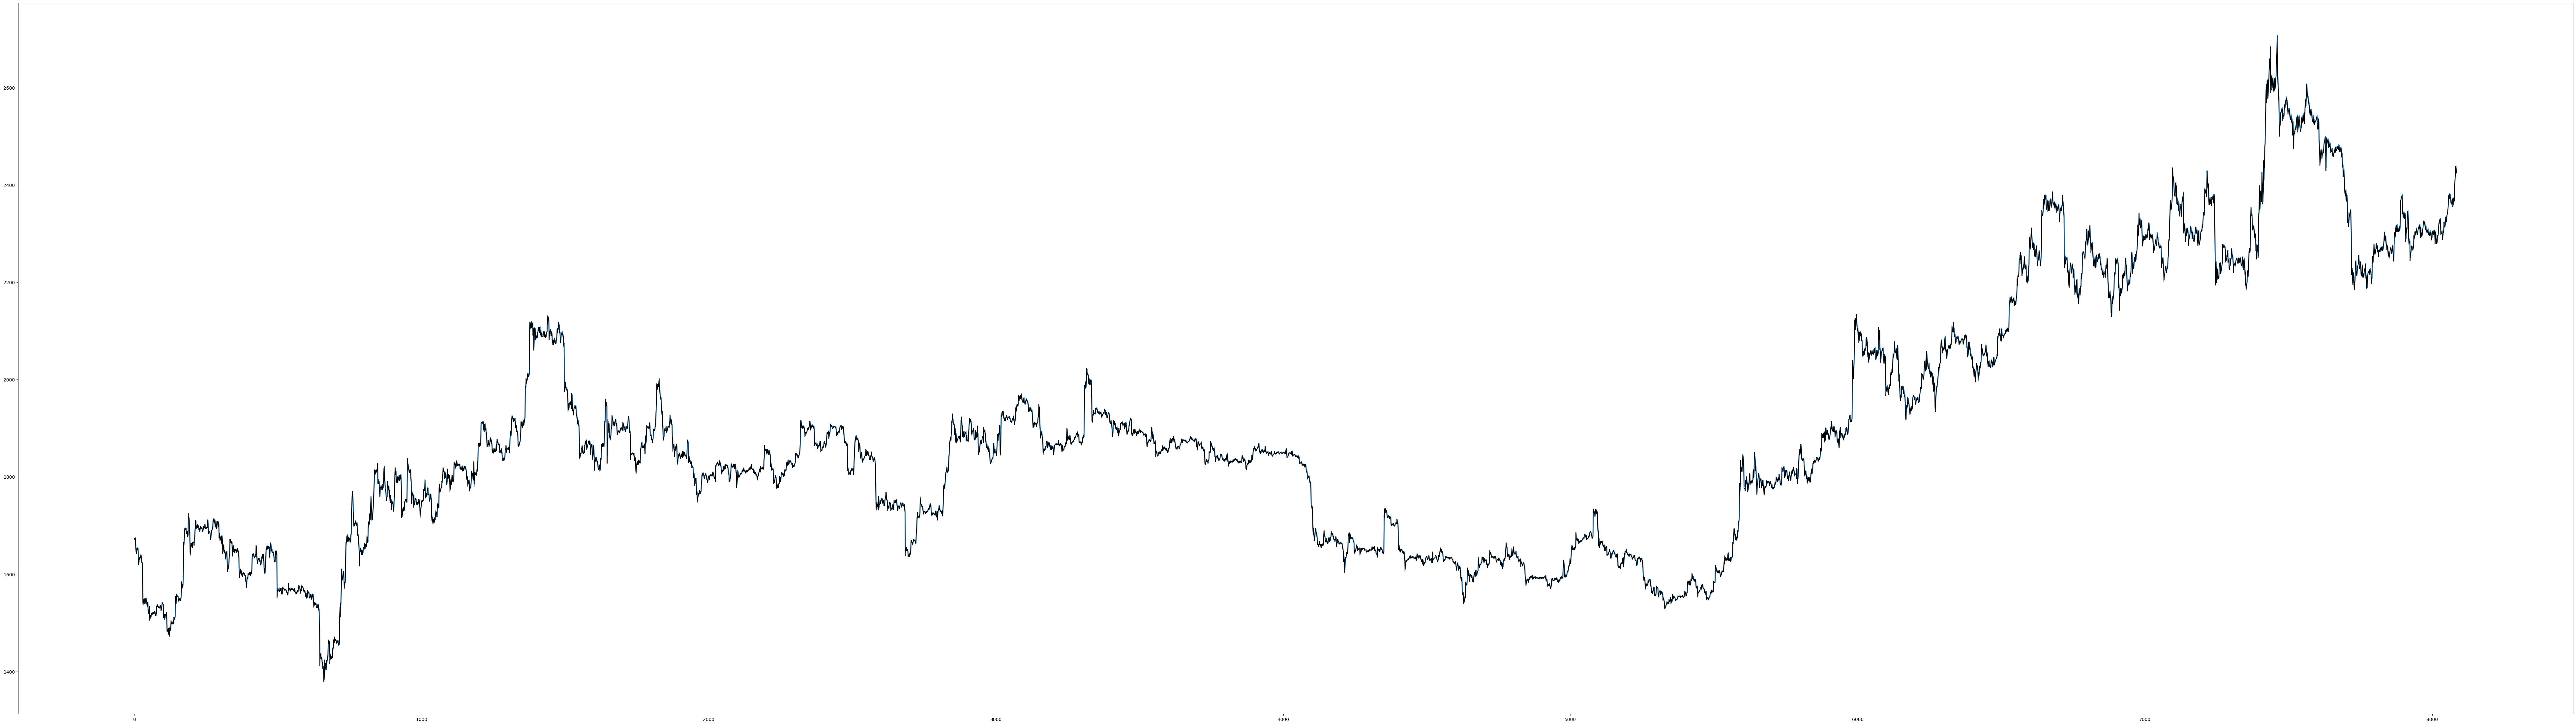

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(100, 28))

plt.plot(y_pred)
plt.plot(data_backup[['close']].shift(-10).values, color='black')
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error, accuracy_score

mean_squared_error(y_pred, data_backup[['close']].iloc[10:])

100.25611387144932

In [20]:
y_pred_series = pd.Series(y_pred.reshape(1,-1)[0])

In [21]:
data_backup['y_pred'] = y_pred_series

In [22]:
data_backup.to_excel('lstm-single-factor.xlsx')